In [ ]:
!pip install botorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 481 kB 5.0 MB/s 
     |████████████████████████████████| 727 kB 61.3 MB/s 
     |████████████████████████████████| 152 kB 53.4 MB/s 
     |████████████████████████████████| 245 kB 62.1 MB/s 


In [ ]:
import os
import math
import torch
import random
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [ ]:
# unknown objective function
from botorch.test_functions import Hartmann

neg_hartmann6 = Hartmann(negate=True)

# Demo for hartmann

## Generate initial conditions

In [ ]:
# generate initial dataset
NOISE_SE = 0.1

def generate_initial_data(n=10):
    # generate random initial locations
    train_x = torch.rand(n, 6, device=device, dtype=dtype)
    # obtain the exact value of the objective function and add output dimension
    exact_obj = neg_hartmann6(train_x).unsqueeze(-1)  
    # add Gaussian noise to the observation model
    train_y = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    # get the current best observed value, i.e., utility of the available dataset
    best_observed_value = train_y.max().item()
    return train_x, train_y, best_observed_value

train_x, train_y, best_observed_value = generate_initial_data(n=5)
print(train_x)
print(train_y)
print(best_observed_value)

tensor([[0.7109, 0.0106, 0.2621, 0.0697, 0.2866, 0.5305],
        [0.0386, 0.5117, 0.8321, 0.8719, 0.2094, 0.1702],
        [0.7290, 0.5147, 0.9309, 0.8339, 0.1056, 0.6658],
        [0.6747, 0.4133, 0.5129, 0.3619, 0.6991, 0.8187],
        [0.5215, 0.8842, 0.3067, 0.2046, 0.1769, 0.1818]], device='cuda:0',
       dtype=torch.float64)
tensor([[ 0.8309],
        [ 0.0752],
        [-0.0698],
        [ 0.0430],
        [ 0.5490]], device='cuda:0', dtype=torch.float64)
0.8308929843287978


In [ ]:
# initialize GP model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

def initialize_model(train_x, train_y):
    # create a single-task exact GP model instance
    # use a GP prior with Matern kernel and constant mean function by default
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    return mll, model

mll, model = initialize_model(train_x, train_y)
list(model.named_hyperparameters())

[('likelihood.noise_covar.raw_noise', Parameter containing:
  tensor([2.0000], device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant', Parameter containing:
  tensor(0., device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale', Parameter containing:
  tensor(0., device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
  tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:0', dtype=torch.float64,
         requires_grad=True))]

In [ ]:
# fit GP hyperparameters
from botorch.fit import fit_gpytorch_mll
# fit hyperparameters (kernel parameters and noise variance) of a GPyTorch model 
fit_gpytorch_mll(mll.cpu());
mll = mll.to(train_x)
model = model.to(train_x)

In [ ]:
print(next(model.parameters()).is_cuda)

True


In [ ]:
list(model.named_hyperparameters())

[('likelihood.noise_covar.raw_noise', Parameter containing:
  tensor([0.0201], device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant', Parameter containing:
  tensor(0.2875, device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale', Parameter containing:
  tensor(-1.5489, device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
  tensor([[-0.8988, -0.9278, -0.9508, -0.9579, -0.9429, -0.9305]],
         device='cuda:0', dtype=torch.float64, requires_grad=True))]

In [ ]:
# define a QMC sampler to sample the acquisition function
from botorch.sampling.normal import SobolQMCNormalSampler

MC_SAMPLES = 256
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

In [ ]:
# use qEI as the MC acquisition function 
from botorch.acquisition import qExpectedImprovement

qEI = qExpectedImprovement(model, best_observed_value, qmc_sampler)

In [ ]:
# optimize and get new observation
from botorch.optim import optimize_acqf

# 6d unit hypercube
bounds = torch.tensor([[0.0] * 6, [1.0] * 6], device=device, dtype=dtype)
# parallel candidate locations generated in each iteration
BATCH_SIZE = 3
# number of starting points for multistart optimization
NUM_RESTARTS = 10
# number of samples for initialization
RAW_SAMPLES = 512

def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values 
    new_x = candidates.detach()
    exact_obj = neg_hartmann6(new_x).unsqueeze(-1)  # add output dimension
    new_y = exact_obj + NOISE_SE * torch.randn_like(exact_obj)

    return new_x, new_y

new_x, new_y = optimize_acqf_and_get_observation(qEI)
print(new_x)
print(new_y)

tensor([[0.9381, 0.0000, 0.2803, 0.0094, 0.3038, 0.4935],
        [0.6015, 0.0000, 0.1978, 0.0167, 0.1881, 0.6974],
        [0.5998, 0.0529, 0.2400, 0.1048, 0.2779, 0.3232]], device='cuda:0',
       dtype=torch.float64)
tensor([[0.2815],
        [0.6528],
        [0.5882]], device='cuda:0', dtype=torch.float64)


In [ ]:
def update_random_observations(best_random):
    """Simulates a random policy by drawing a BATCH_SIZE of new random points, 
        observing their values, and updating the current best candidate to the running list.
    """
    rand_x = torch.rand(BATCH_SIZE, 6)
    next_random_best = neg_hartmann6(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))       
    return best_random

# BO loop for hartmann

In [ ]:
import time
from botorch.acquisition import qKnowledgeGradient

# number of runs to assess std of different BO loops
N_TRIALS = 3
# indicator to print diagnostics
verbose = True
# number of steps in the outer BO loop
N_BATCH = 20 
best_observed_all_qei, best_observed_all_qkg, best_random_all = [], [], []

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_qei, best_observed_qkg, best_random = [], [], []
    
    # call helper functions to generate initial training data and initialize model
    train_x_qei, train_y_qei, best_observed_value_qei = generate_initial_data(n=10)
    mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
    
    train_x_qkg, train_y_qkg = train_x_qei, train_y_qei
    best_observed_value_qkg = best_observed_value_qei
    mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

    best_observed_qei.append(best_observed_value_qei)
    best_observed_qkg.append(best_observed_value_qkg)
    best_random.append(best_observed_value_qei)
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        
        t0 = time.monotonic()
        
        # fit the models
        fit_gpytorch_mll(mll_qei.cpu());
        mll_qei = mll_qei.to(train_x)
        model_qei = model_qei.to(train_x)

        fit_gpytorch_mll(mll_qkg.cpu());
        mll_qkg = mll_qkg.to(train_x)
        model_qkg = model_qkg.to(train_x)
        
        # define the qEI acquisition function using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
        
        # for best_f, we use the best observed noisy values as an approximation
        qEI = qExpectedImprovement(
            model = model_qei, 
            best_f = train_y.max(),
            sampler = qmc_sampler
        )

        qKG = qKnowledgeGradient(model_qkg, num_fantasies=MC_SAMPLES)
        
        # optimize and get new observation
        new_x_qei, new_y_qei = optimize_acqf_and_get_observation(qEI)
        new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation(qKG)
                
        # update training points
        train_x_qei = torch.cat([train_x_qei, new_x_qei])
        train_y_qei = torch.cat([train_y_qei, new_y_qei])
        train_x_qkg = torch.cat([train_x_qkg, new_x_qkg])
        train_y_qkg = torch.cat([train_y_qkg, new_y_qkg])

        # update progress
        best_random = update_random_observations(best_random)
        best_value_qei = neg_hartmann6(train_x_qei).max().item()
        best_value_qkg = neg_hartmann6(train_x_qkg).max().item()
        best_observed_qei.append(best_value_qei)
        best_observed_qkg.append(best_value_qkg)

        # reinitialize the models so they are ready for fitting on next iteration
        mll_qei, model_qei = initialize_model(
            train_x_qei, 
            train_y_qei
        )
        mll_qkg, model_qkg = initialize_model(
            train_x_qkg, 
            train_y_qkg
        )
        
        t1 = time.monotonic()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI, qKG) = "
                f"({max(best_random):>4.2f}, {best_value_qei:>4.2f}, {best_value_qkg:>4.2f}),"
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    best_observed_all_qei.append(best_observed_qei)
    best_observed_all_qkg.append(best_observed_qkg)
    best_random_all.append(best_random)


Trial  1 of 3 
Batch  1: best_value (random, qEI, qKG) = (0.61, 1.50, 0.89),time = 17.81.
Batch  2: best_value (random, qEI, qKG) = (0.61, 2.03, 2.06),time = 14.72.
Batch  3: best_value (random, qEI, qKG) = (0.61, 2.34, 2.66),time = 15.25.
Batch  4: best_value (random, qEI, qKG) = (0.61, 2.69, 2.66),time = 14.05.
Batch  5: best_value (random, qEI, qKG) = (0.95, 2.77, 3.10),time = 13.95.
Batch  6: best_value (random, qEI, qKG) = (0.95, 2.80, 3.10),time = 14.01.
Batch  7: best_value (random, qEI, qKG) = (0.95, 2.80, 3.10),time = 15.14.
Batch  8: best_value (random, qEI, qKG) = (0.95, 2.80, 3.10),time = 13.96.
Batch  9: best_value (random, qEI, qKG) = (0.95, 2.80, 3.10),time = 14.52.
Batch 10: best_value (random, qEI, qKG) = (0.95, 2.80, 3.13),time = 14.61.
Batch 11: best_value (random, qEI, qKG) = (0.95, 2.80, 3.13),time = 14.26.
Batch 12: best_value (random, qEI, qKG) = (0.95, 2.87, 3.18),time = 15.22.
Batch 13: best_value (random, qEI, qKG) = (0.95, 2.92, 3.19),time = 15.39.
Batch 14:

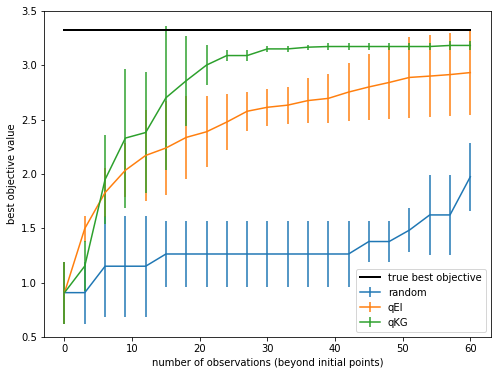

In [ ]:
# plot the results
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

GLOBAL_MAXIMUM = neg_hartmann6.optimal_value

iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_all_qei)
y_kg = np.asarray(best_observed_all_qkg)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="qEI", linewidth=1.5)
ax.errorbar(iters, y_kg.mean(axis=0), yerr=ci(y_kg), label="qKG", linewidth=1.5)
plt.plot([0, N_BATCH * BATCH_SIZE], [GLOBAL_MAXIMUM] * 2, 'k', label="true best objective", linewidth=2)
ax.set_ylim(bottom=0.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
ax.legend(loc="lower right")

# Demo for MNIST

In [ ]:
# Download MNIST dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
print(train_data.data.size())
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


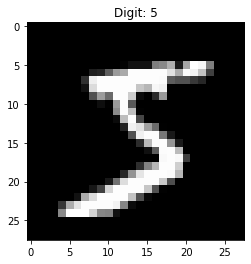

In [ ]:
# Plot the first image
plt.imshow(train_data.data[0], cmap='gray')
plt.title("Digit: {}".format(train_data.targets[0]))
plt.show()

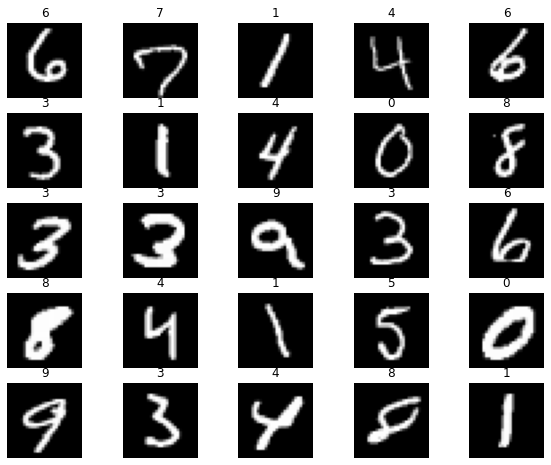

In [ ]:
# Plot multiple images
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
# Loop over 25 places to plot the images
for i in range(1, cols * rows + 1):
    # Generate a random index to select an image
    # The item function converts the Tensor object into a scalar value
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    # Extract the image data and target label
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    # Squeeze the image to convert the image shape from [1,28,28] to [28,28]
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# Preparing data for training with DataLoaders
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, # data source to be loaded
                                          batch_size=100, #  the number of training samples used in one iteration
                                          shuffle=True), # samples are shuffled and loaded in batches
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True)}

In [ ]:
for X, y in loaders['train']:
    print("Shape of X [batch_size, channel, height, width]: ", X.shape)
    print("Shape of y: ", y.shape)
    break

Shape of X [batch_size, channel, height, width]:  torch.Size([100, 1, 28, 28])
Shape of y:  torch.Size([100])


In [ ]:
# Define the Convolutional Neural Network model class
import torch.nn as nn
class CNN(nn.Module):
    # Specify the components to be created automatically upon instantiation
    def __init__(self):
        super(CNN, self).__init__()
        # The first convolutional block
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        # The second convolutional block
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # The final fully connected layer which outputs 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    # Specify the flow of information
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # Flatten the output to shape (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model_cnn = CNN().to(device)
print(model_cnn)

Using cuda device
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
from torchsummary import summary
summary(model_cnn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 10]          15,690
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.11
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


In [ ]:
# Define the cost function
loss = nn.CrossEntropyLoss().cuda()

In [ ]:
# Define the optimizer
from torch import optim
optimizer = optim.SGD(model_cnn.parameters(), lr = 0.01)   
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [ ]:
# Define the training function
def train(model, loaders, verbose=True):
    # Control the behavior of certain layers by specifying the training mode
    model.train()
    # Extract the total number of images to track training progress
    total_img = len(loaders['train'].dataset)
    # Extract and iterate through each batch of training data
    for batch, (X, y) in enumerate(loaders['train']):
        # Pass to GPU for faster processing
        X, y = X.to(device), y.to(device)
        # Call the forward method (under the hood) to produce prediction
        pred = model(X)       
        # Calculate the current loss
        loss_fn = nn.CrossEntropyLoss().cuda()
        loss = loss_fn(pred, y)
        # Clear existing gradients
        optimizer.zero_grad()           
        # Perform backpropagation and compute gradients 
        loss.backward()    
        # Update weights using SGD
        optimizer.step()       
        # Print loss at every 100th batch; each batch has 100 image-label pairs
        if(verbose):
            if batch % 100 == 0:
                loss, current_img_idx = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current_img_idx:>5d}/{total_img:>5d}]") 


In [ ]:
# Define the test function
def test(model, loaders, verbose=True):
    # Control the behavior of certain layers by specifying the evaluation mode
    model.eval()
    # Extract the total number of images to in the test set
    total_img = len(loaders['test'].dataset)
    correct = 0
    # Disable gradient calculation
    with torch.no_grad():
        for X, y in loaders['test']:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # Add the correct prediction for each batch
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= total_img

    if verbose:
        print(f"Test accuracy: {correct:>0.3f}")
        
    return correct

In [ ]:
num_epochs = 3
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model_cnn, loaders, verbose=False)
    test_accuracy = test(model_cnn, loaders, verbose=True)
print("Done!")

Epoch 1
-------------------------------
Test accuracy: 0.914
Epoch 2
-------------------------------
Test accuracy: 0.937
Epoch 3
-------------------------------
Test accuracy: 0.957
Done!


# BO loop for CNN

In [ ]:
from torch.autograd import Variable

class CNN_CLASSIFIER(nn.Module):
    # Specify the components to be created automatically upon instantiation
    def __init__(self, loaders, num_epochs=10, verbose_train=False, verbose_test=False):
        super(CNN_CLASSIFIER, self).__init__()
        self.loaders = loaders
        self.num_epochs = num_epochs
        self.model = CNN().to(device)
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.verbose_train = verbose_train
        self.verbose_test = verbose_test
   
    def forward(self, learning_rate):
        self.optimizer = optim.SGD(self.model.parameters(), lr = learning_rate)

        for t in range(self.num_epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            self.train(verbose=self.verbose_train)
            test_accuracy = self.test(verbose=self.verbose_test)
        
        return test_accuracy

    # Define the training function
    def train(self, verbose=False):
        # Control the behavior of certain layers by specifying the training mode
        self.model.train()
        # Extract the total number of images to track training progress
        total_img = len(self.loaders['train'].dataset)
        # Extract and iterate through each batch of training data
        for batch, (X, y) in enumerate(self.loaders['train']):
            # send to GPU if available
            X, y = Variable(X).cuda(), Variable(y).cuda()
            # Call the forward method (under the hood) to produce prediction
            pred = self.model(X)               
            # Calculate the current loss
            loss = self.criterion(pred, y)
            # Clear existing gradients
            self.optimizer.zero_grad()           
            # Perform backpropagation and compute gradients 
            loss.backward()    
            # Update weights using SGD
            self.optimizer.step()       
            # Print loss at every 100th batch; each batch has 100 image-label pairs
            if(verbose):
                if batch % 100 == 0:
                    loss, current_img_idx = loss.item(), batch * len(X)
                    print(f"loss: {loss:>7f}  [{current_img_idx:>5d}/{total_img:>5d}]")  
        return self

    # Define the test function
    def test(self, verbose=False):
        # Control the behavior of certain layers by specifying the evaluation mode
        self.model.eval()
        # Extract the total number of images to in the test set
        total_img = len(self.loaders['test'].dataset)
        correct = 0
        # Disable gradient calculation
        with torch.no_grad():
            for X, y in self.loaders['test']:
                X, y = X.to(device), y.to(device)
                pred = self.model(X)
                # Add the correct prediction for each batch
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= total_img

        if verbose:
            print(f"Test accuracy: {correct:>0.3f}")
            
        return correct    

In [ ]:
nn_classifier = CNN_CLASSIFIER(loaders=loaders, num_epochs=3, verbose_test=True)

In [ ]:
nn_classifier(learning_rate=0.01)

Epoch 1
-------------------------------
Test accuracy: 0.902
Epoch 2
-------------------------------
Test accuracy: 0.938
Epoch 3
-------------------------------
Test accuracy: 0.953


0.9531

## Start BO loop

In [ ]:
# generate initial dataset
NOISE_SE = 0

def generate_initial_data_cnn(n=5):
    # generate training data
    # train_x = torch.rand(n, 1, device=device, dtype=dtype)
    train_x = torch.distributions.uniform.Uniform(0.0001,10).sample([n,1]).type(torch.DoubleTensor).cuda()
    train_y = []
    for tmp_x in train_x:
        print(f"\nCurrent learning rate: {tmp_x.item()}")
        nn_classifier = CNN_CLASSIFIER(loaders=loaders, num_epochs=3, verbose_test=True)
        tmp_y = nn_classifier(learning_rate=tmp_x.item())
        train_y.append(tmp_y)

    train_y = torch.tensor([[tmp] for tmp in train_y]).type(torch.DoubleTensor).cuda()
    best_observed_value = train_y.max().item()
    return train_x, train_y, best_observed_value

train_x, train_y, best_observed_value = generate_initial_data_cnn(n=3)
print(train_x)
print(train_y)
print(best_observed_value)


Current learning rate: 6.010292053222656
Epoch 1
-------------------------------
Test accuracy: 0.101
Epoch 2
-------------------------------
Test accuracy: 0.114
Epoch 3
-------------------------------
Test accuracy: 0.103

Current learning rate: 2.8877639770507812
Epoch 1
-------------------------------
Test accuracy: 0.114
Epoch 2
-------------------------------
Test accuracy: 0.103
Epoch 3
-------------------------------
Test accuracy: 0.101

Current learning rate: 5.03461217880249
Epoch 1
-------------------------------
Test accuracy: 0.114
Epoch 2
-------------------------------
Test accuracy: 0.098
Epoch 3
-------------------------------
Test accuracy: 0.098
tensor([[6.0103],
        [2.8878],
        [5.0346]], device='cuda:0', dtype=torch.float64)
tensor([[0.1032],
        [0.1010],
        [0.0980]], device='cuda:0', dtype=torch.float64)
0.10320000350475311


In [ ]:
mll, model = initialize_model(train_x, train_y)

In [ ]:
from botorch.fit import fit_gpytorch_mll
fit_gpytorch_mll(mll.cpu());
mll = mll.to(train_x)
model = model.to(train_x)

In [ ]:
from botorch.sampling.normal import SobolQMCNormalSampler
MC_SAMPLES = 256
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

In [ ]:
from botorch.acquisition import qExpectedImprovement
qEI = qExpectedImprovement(
            model = model.cuda(), 
            best_f = train_y.max().cuda(),
            sampler = qmc_sampler
        )

In [ ]:
from botorch.optim import optimize_acqf
bounds = torch.tensor([[0.0001], [10.0]], device=device, dtype=dtype)
BATCH_SIZE = 3
NUM_RESTARTS = 10
RAW_SAMPLES = 512

def optimize_acqf_and_get_observation_cnn(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values 
    new_x = candidates.detach()
    # exact_obj = neg_hartmann6(new_x).unsqueeze(-1)  # add output dimension
    # new_y = exact_obj + NOISE_SE * torch.randn_like(exact_obj)

    new_y = []
    for tmp_x in new_x:
        print(f"\nCurrent learning rate: {tmp_x.item()}")
        nn_classifier = CNN_CLASSIFIER(loaders=loaders, num_epochs=3, verbose_test=True)
        tmp_y = nn_classifier(learning_rate=tmp_x.item())
        new_y.append(tmp_y)

    new_y = torch.tensor([[tmp] for tmp in new_y]).type(torch.DoubleTensor).cuda()

    return new_x, new_y

new_x_qei, new_y_qei = optimize_acqf_and_get_observation_cnn(qEI)


Current learning rate: 0.16031635553078796
Epoch 1
-------------------------------
Test accuracy: 0.967
Epoch 2
-------------------------------
Test accuracy: 0.985
Epoch 3
-------------------------------
Test accuracy: 0.988

Current learning rate: 10.0
Epoch 1
-------------------------------
Test accuracy: 0.098
Epoch 2
-------------------------------
Test accuracy: 0.103
Epoch 3
-------------------------------
Test accuracy: 0.096

Current learning rate: 7.918584098817325
Epoch 1
-------------------------------
Test accuracy: 0.114
Epoch 2
-------------------------------
Test accuracy: 0.114
Epoch 3
-------------------------------
Test accuracy: 0.101


In [ ]:
print(new_x_qei)
print(new_y_qei)

tensor([[ 0.1603],
        [10.0000],
        [ 7.9186]], device='cuda:0', dtype=torch.float64)
tensor([[0.9875],
        [0.0958],
        [0.1010]], device='cuda:0', dtype=torch.float64)


In [ ]:
def update_random_observations_cnn(best_random):
    """Simulates a random policy by drawing a BATCH_SIZE of new random points, 
        observing their values, and updating the currect best candidate to the running list.
    """

    rand_x = torch.distributions.uniform.Uniform(0.0001,10).sample([BATCH_SIZE,1]).type(torch.DoubleTensor).cuda()
    rand_y = []
    for tmp_x in rand_x:
        print(f"\nCurrent learning rate: {tmp_x.item()}")
        nn_classifier = CNN_CLASSIFIER(loaders=loaders, num_epochs=3, verbose_test=True)
        tmp_y = nn_classifier(learning_rate=tmp_x.item())
        rand_y.append(tmp_y)

    rand_y = torch.tensor([[tmp] for tmp in rand_y]).type(torch.DoubleTensor).cuda()
    next_random_best = rand_y.max().item()
    best_random.append(max(best_random[-1], next_random_best))       

    return best_random

In [ ]:
update_random_observations_cnn(best_random)


Current learning rate: 9.98404312133789
Epoch 1
-------------------------------
Test accuracy: 0.101
Epoch 2
-------------------------------
Test accuracy: 0.114
Epoch 3
-------------------------------
Test accuracy: 0.098

Current learning rate: 9.740055084228516
Epoch 1
-------------------------------
Test accuracy: 0.098
Epoch 2
-------------------------------
Test accuracy: 0.114
Epoch 3
-------------------------------
Test accuracy: 0.096

Current learning rate: 4.662008285522461
Epoch 1
-------------------------------
Test accuracy: 0.097
Epoch 2
-------------------------------
Test accuracy: 0.098
Epoch 3
-------------------------------
Test accuracy: 0.103


[1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 1.227995411568301,
 2.2823081016540527,
 2.2823081016540527]

In [ ]:
# number of runs to assess std of different BO loops
N_TRIALS = 3
# indicator to print diagnostics
verbose = True
# number of steps in the outer BO loop
N_BATCH = 10
best_observed_all_qei, best_observed_all_qkg, best_random_all = [], [], []

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_qei, best_observed_qkg, best_random = [], [], []
    
    # call helper functions to generate initial training data and initialize model
    train_x_qei, train_y_qei, best_observed_value_qei = generate_initial_data_cnn(n=3)
    mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
    
    train_x_qkg, train_y_qkg = train_x_qei, train_y_qei
    best_observed_value_qkg = best_observed_value_qei
    mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

    best_observed_qei.append(best_observed_value_qei)
    best_observed_qkg.append(best_observed_value_qkg)
    best_random.append(best_observed_value_qei)

    t0_total = time.monotonic()
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        t0 = time.monotonic()
        
        # fit the models
        fit_gpytorch_mll(mll_qei.cpu());
        mll_qei = mll_qei.to(train_x)
        model_qei = model_qei.to(train_x)

        fit_gpytorch_mll(mll_qkg.cpu());
        mll_qkg = mll_qkg.to(train_x)
        model_qkg = model_qkg.to(train_x)
        
        # define the qEI acquisition function using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
        
        # for best_f, we use the best observed noisy values as an approximation
        qEI = qExpectedImprovement(
            model = model_qei, 
            best_f = train_y.max(),
            sampler = qmc_sampler
        )

        qKG = qKnowledgeGradient(model_qkg, num_fantasies=MC_SAMPLES)
        
        # optimize and get new observation
        new_x_qei, new_y_qei = optimize_acqf_and_get_observation_cnn(qEI)
        new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation_cnn(qKG)
                
        # update training points
        train_x_qei = torch.cat([train_x_qei, new_x_qei])
        train_y_qei = torch.cat([train_y_qei, new_y_qei])
        train_x_qkg = torch.cat([train_x_qkg, new_x_qkg])
        train_y_qkg = torch.cat([train_y_qkg, new_y_qkg])

        # update progress
        best_random = update_random_observations_cnn(best_random)
        best_value_qei = max(best_observed_qei[-1], new_y_qei.max().item())
        best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.max().item())
        best_observed_qei.append(best_value_qei)
        best_observed_qkg.append(best_value_qkg)

        # reinitialize the models so they are ready for fitting on next iteration
        mll_qei, model_qei = initialize_model(
            train_x_qei, 
            train_y_qei
        )
        mll_qkg, model_qkg = initialize_model(
            train_x_qkg, 
            train_y_qkg
        )
        
        t1 = time.monotonic()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI, qKG) = "
                f"({max(best_random):>4.2f}, {best_value_qei:>4.2f}, {best_value_qkg:>4.2f}),"
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    best_observed_all_qei.append(best_observed_qei)
    best_observed_all_qkg.append(best_observed_qkg)
    best_random_all.append(best_random)

    t1_total = time.monotonic()
    print(f"total time = {t1_total-t0_total:>4.2f}.")


Trial  1 of 3 
Current learning rate: 7.937699794769287
Epoch 1
-------------------------------
Test accuracy: 0.114
Epoch 2
-------------------------------
Test accuracy: 0.096
Epoch 3
-------------------------------
Test accuracy: 0.101

Current learning rate: 5.048965930938721
Epoch 1
-------------------------------
Test accuracy: 0.101
Epoch 2
-------------------------------
Test accuracy: 0.103
Epoch 3
-------------------------------
Test accuracy: 0.101

Current learning rate: 0.08593519777059555
Epoch 1
-------------------------------
Test accuracy: 0.978
Epoch 2
-------------------------------
Test accuracy: 0.983
Epoch 3
-------------------------------
Test accuracy: 0.987

Current learning rate: 0.32507211315710677
Epoch 1
-------------------------------
Test accuracy: 0.980
Epoch 2
-------------------------------
Test accuracy: 0.985
Epoch 3
-------------------------------
Test accuracy: 0.987

Current learning rate: 0.0001
Epoch 1
-------------------------------
Test accur

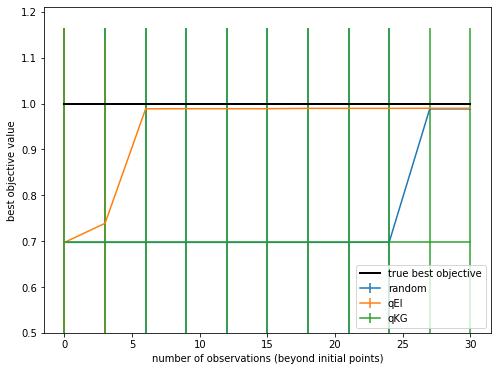

In [ ]:
# plot the results
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_all_qei)
y_kg = np.asarray(best_observed_all_qkg)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="qEI", linewidth=1.5)
ax.errorbar(iters, y_kg.mean(axis=0), yerr=ci(y_kg), label="qKG", linewidth=1.5)
plt.plot([0, N_BATCH * BATCH_SIZE], [1] * 2, 'k', label="true best objective", linewidth=2)
ax.set_ylim(bottom=0.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
ax.legend(loc="lower right")